# MALA proposal example: Rosenbrock Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import tinyDA as tda

Ray module not found. Multiprocessing features are not available


In [2]:
np.random.seed(123)

### Defining the true model and generating some data

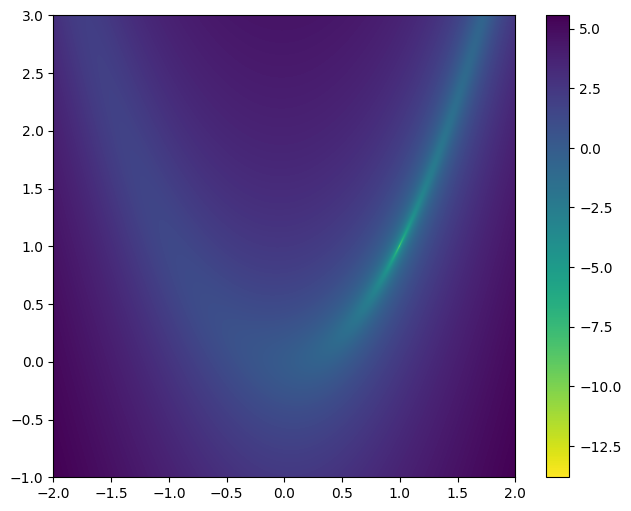

In [3]:
# An example of the Rosenbrock function, which is the first function
# that we will try and estimate with the MCMC.
def rosenbrock(x,y,a=1,b=10):
    return (a-x)**2 + b*(y-x**2)**2

xx = np.linspace(-2,2, 1000); yy = np.linspace(-1,3, 1000); X, Y = np.meshgrid(xx,yy)
surf = rosenbrock(X,Y)
plt.figure(figsize = (8,6))
# The log of the function values are plotted since it scales better with the colormap.
plt.imshow(np.log(surf), origin = 'lower', cmap = 'viridis_r', extent = [-2, 2, -1, 3]); plt.colorbar()
plt.show()

### Set up the statistical model

In [4]:
# set the prior
mean_prior = np.zeros(2)
cov_prior = np.eye(2)
my_prior = multivariate_normal(mean_prior, cov_prior)

# set the likelihood
y = np.array([0])
cov_likelihood = np.eye(y.shape[0])
my_loglike = tda.GaussianLogLike(y, cov_likelihood)

In [5]:
class MyModel:
    def __init__(self, model):
        self.model = model
    def __call__(self, parameters):
        return self.model(parameters[0], parameters[1])
    def gradient(self, parameters, sensitivity):
        dFdx = 2*(20*parameters[0]**3 - 20*parameters[0]*parameters[1] + parameters[0] - 1)
        dFdy = 20*(parameters[1] - parameters[0]**2)
        jacobian = np.array([[dFdx, dFdy]])
        return np.dot(sensitivity, jacobian)

In [6]:
my_model = MyModel(rosenbrock)

In [7]:
# initialise the LinkFactory
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

### Set up the proposal

In [8]:
# random walk Metropolis
#rwmh_cov = np.eye(2)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# preconditioned Crank-Nicolson
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(adaptive=pcn_adaptive)

mala_scaling = 0.01
mala_adaptive = True
my_proposal = tda.MALA(scaling=mala_scaling, adaptive=mala_adaptive)

### Sample

In [9]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 25000
    burnin = 5000

In [10]:
my_chains = tda.sample(my_posterior, my_proposal, iterations=iterations, n_chains=2, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.59:  11%|█▏         | 2817/25000 [00:01<00:14, 1554.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Running chain, α = 0.58:  34%|███▊       | 8606/25000 [00:04<00:11, 1486.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Running chain, α = 0.61:  58%|█████▊    | 14381/25000 [00:09<00:08, 1182.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

### Get some diagnostics

In [11]:
import arviz as az

In [12]:
idata = tda.to_inference_data(my_chains, burnin=burnin)

/home/mikkel/.cache/pypoetry/virtualenvs/tinyda-p_DUFDjW-py3.10/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,0.461,0.383,-0.255,1.153,0.013,0.011,855.0,774.0,1.0
theta_1,0.340,0.413,-0.305,1.143,0.016,0.012,906.0,688.0,1.0


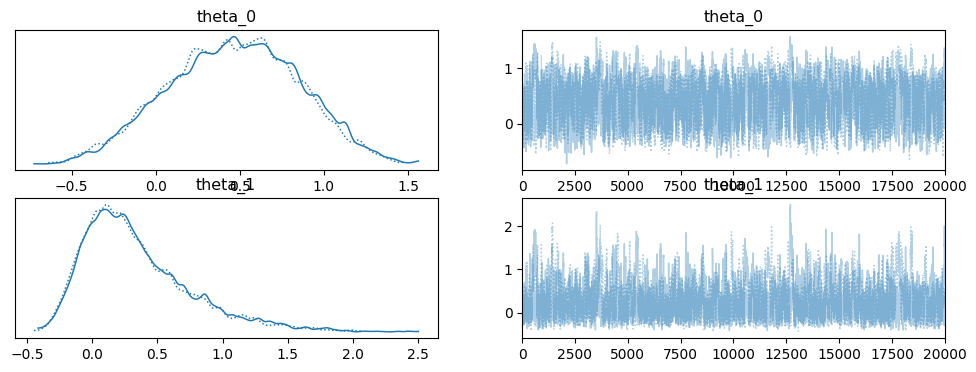

In [14]:
az.plot_trace(idata)
plt.show()

In [15]:
parameters = np.array([link.parameters for link in my_chains['chain_0'][burnin:] + my_chains['chain_1'][burnin:]])

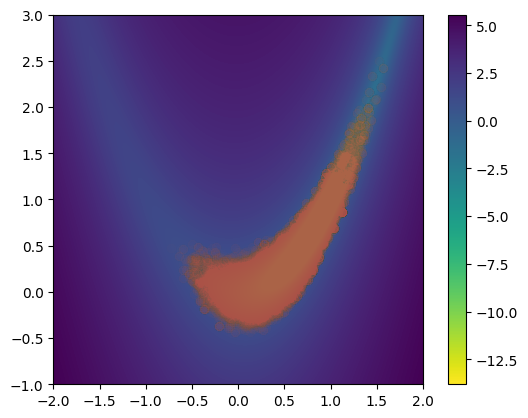

In [16]:
plt.imshow(np.log(surf), origin = 'lower', cmap = 'viridis_r', extent = [-2, 2, -1, 3]); plt.colorbar()
plt.scatter(parameters[:,0], parameters[:,1], c='tomato', alpha=0.01)
plt.show()